In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch.nn as nn
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
import joblib
warnings.filterwarnings("ignore")

# Task 1

The goal of this Jupyter notebook is to develop a machine learning model that categorizes users as either organic or paid, and to save the final model using the pickle library.

In [3]:
data = pd.read_pickle('/content/drive/MyDrive/dataset_academy.pickle')

## Data preparation

Before training the machine learning models, the data needs to be explored and cleaned.

### Data Cleaning and Quality Check

We can see that our dataset consists of 126,870 rows and 22 features.

In [4]:
print(data.shape)
data.head(3)

(126870, 22)


,user_id,avg_open_team,avg_open_event,avg_open_league,avg_open_player,avg_open_matches,avg_open_lineups,avg_open_sport,avg_open_overs,avg_open_fight_night,...,avg_follow_player,avg_follow_league,avg_chat_activity,avg_chat_action,avg_ads_impression_custom,avg_odds_impression,avg_total_screen_time,avg_num_distinct_events,geo_country,campaign
28648,2e26d3769e9311c8dba02ba7376f9c03,0.064516,0.483871,0.064516,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.741935,0.451613,41859.258065,2.129032,Brazil,And_GA_BR_valuable_cpc
120343,c2bf754aa582c17b29f0d7e57aaadcce,0.000000,0.838710,0.064516,0.129032,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.129032,120081.419355,1.064516,Gambia,<organic>
41493,4301ff35fa086ec4bd8749f73d40b6d0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,182.870968,0.129032,Brazil,And_MO_WW_Install


In [5]:
data.reset_index(drop=True, inplace=True)

Using `isna()`, we check for missing values in the dataset and find that there are none.

In [6]:
data.isna().sum()

,0
user_id,0
avg_open_team,0
avg_open_event,0
avg_open_league,0
avg_open_player,0
avg_open_matches,0
avg_open_lineups,0
avg_open_sport,0
avg_open_overs,0
avg_open_fight_night,0


Using `nunique`, we observe that the number of unique user_id values is equal to the number of rows in the dataset `(126870)`. This indicates that user_id is a unique identifier and does not carry any predictive power for our analysis. Therefore, we drop this feature.

In [7]:
data.nunique()

,0
user_id,126870
avg_open_team,684
avg_open_event,2137
avg_open_league,312
avg_open_player,498
avg_open_matches,183
avg_open_lineups,195
avg_open_sport,21
avg_open_overs,3
avg_open_fight_night,17


In [8]:
data.drop(columns=['user_id'], inplace=True)

We also check for columns with monotonically increasing or decreasing values (such as an ID or similar), as well as constant columns, since such features are generally not useful for analysis. However, we find that there are no such columns in the dataset.

In [9]:
constant_columns = []
monotonic_increasing_columns = []
monotonic_decreasing_columns = []

for col in data.columns:
    if data[col].nunique() <= 1:
        constant_columns.append(col)
    elif data[col].is_monotonic_increasing:
        monotonic_increasing_columns.append(col)
    elif data[col].is_monotonic_decreasing:
        monotonic_decreasing_columns.append(col)

print("Constant columns:", constant_columns)
print("Monotonically increasing columns:", monotonic_increasing_columns)
print("Monotonically decreasing columns:", monotonic_decreasing_columns)


Constant columns: []
Monotonically increasing columns: []
Monotonically decreasing columns: []


We create a binary column `is_organic` based on the values in the `campaign` column, which will serve as our target variable. After that, we drop the campaign column since it is no longer needed.

In [10]:
print(data['campaign'].value_counts())

campaign
<organic>                               55008
And_GA_BR_valuable_cpc                  10518
And_GA_T3_valuable_cpc_#2                8546
And_GA_WW_Install_valuable_cpc           4703
And_GA_T1_valuable_cpc_#2                3760
                                        ...  
Sofascore - Sports live scores_NG           1
And_GA_RS_valuable_cpc                      1
Realmadridcf_4ever                          1
And_GA_ZA_valuable_cpc (19240001677)        1
And_GA_NG_Install                           1
Name: count, Length: 153, dtype: int64


In [11]:
data['is_organic'] = (data['campaign'] == '<organic>').astype(int)
data.drop(columns=['campaign'], inplace=True)
data.head(3)

,avg_open_team,avg_open_event,avg_open_league,avg_open_player,avg_open_matches,avg_open_lineups,avg_open_sport,avg_open_overs,avg_open_fight_night,avg_open_stage,...,avg_follow_player,avg_follow_league,avg_chat_activity,avg_chat_action,avg_ads_impression_custom,avg_odds_impression,avg_total_screen_time,avg_num_distinct_events,geo_country,is_organic
0,0.064516,0.483871,0.064516,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.741935,0.451613,41859.258065,2.129032,Brazil,0
1,0.000000,0.838710,0.064516,0.129032,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.129032,120081.419355,1.064516,Gambia,1
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,182.870968,0.129032,Brazil,0


Additionally, we create lists of categorical, numerical, and target columns which will be used later for feature transformation.

In [12]:
target_column = ['is_organic']

numerical_columns = [col for col in data.select_dtypes(include=['number']).columns if col not in target_column]
categorical_columns = [col for col in data.select_dtypes(include=['object']).columns if col not in target_column]

print("Numeric columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

Numeric columns: ['avg_open_team', 'avg_open_event', 'avg_open_league', 'avg_open_player', 'avg_open_matches', 'avg_open_lineups', 'avg_open_sport', 'avg_open_overs', 'avg_open_fight_night', 'avg_open_stage', 'avg_follow_team', 'avg_follow_player', 'avg_follow_league', 'avg_chat_activity', 'avg_chat_action', 'avg_ads_impression_custom', 'avg_odds_impression', 'avg_total_screen_time', 'avg_num_distinct_events']
Categorical columns: ['geo_country']


In [13]:
def plot_user_distribution(data, target_col='is_organic'):
    counts = data[target_col].value_counts().sort_index()
    labels = ['Paid Users', 'Organic Users']

    colors = ['#ADB8E8', '#FFB700']

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.bar(counts.index, counts.values, color=colors)
    plt.title('Count of Paid vs Organic Users')
    plt.xlabel('User Type')
    plt.ylabel('Count')
    plt.xticks(ticks=counts.index, labels=labels)

    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title('Distribution of Paid vs Organic Users')

    plt.tight_layout()
    plt.show()

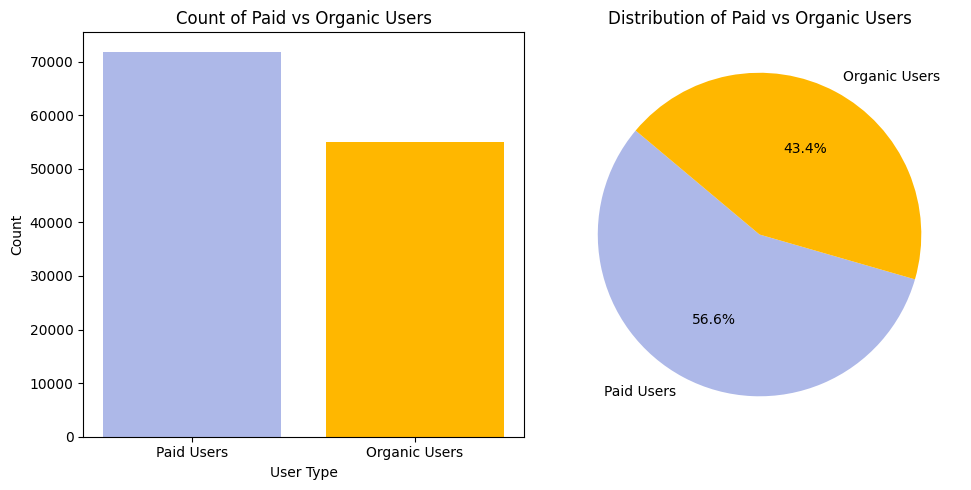

In [14]:
plot_user_distribution(data, 'is_organic')

The visuals show that 43.4% of users are organic and the rest are paid users, which means the classes are pretty well balanced.

### Feature transformation

We will use one-hot encoding to transform the categorical features (only geo_country in our case) and apply StandardScaler to scale the numerical features.

In [15]:
def preprocess_data(data_transformed, numerical_columns, categorical_columns, scale=True, encode=True):
    # Scale numerical features
    if scale:
        scaler = StandardScaler()
        data_transformed[numerical_columns] = scaler.fit_transform(data_transformed[numerical_columns])

    # One-hot encode categorical features
    if encode:
        data_transformed = pd.get_dummies(data_transformed, columns=categorical_columns, drop_first=True).astype(float)

    return data_transformed

In [16]:
data_transformed = preprocess_data(data.copy(), numerical_columns, categorical_columns)
print(data_transformed.shape)
data_transformed.head(3)

(126870, 214)


,avg_open_team,avg_open_event,avg_open_league,avg_open_player,avg_open_matches,avg_open_lineups,avg_open_sport,avg_open_overs,avg_open_fight_night,avg_open_stage,...,geo_country_United Kingdom,geo_country_United States,geo_country_Uruguay,geo_country_Uzbekistan,geo_country_Venezuela,geo_country_Vietnam,geo_country_Western Sahara,geo_country_Yemen,geo_country_Zambia,geo_country_Zimbabwe
0,-0.124094,-0.194204,-0.134826,-0.123051,-0.030384,-0.034079,-0.008135,-0.00397,-0.028948,-0.012548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.159697,-0.157128,-0.134826,-0.013755,-0.030384,-0.034079,-0.008135,-0.00397,-0.028948,-0.012548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.159697,-0.244761,-0.243580,-0.123051,-0.030384,-0.034079,-0.008135,-0.00397,-0.028948,-0.012548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Models

### Basic ML models

Since this is a binary classification problem, using complex deep models like convolutional neural networks seems a bit unnecessary. We will start with the following predefined models:

- `Logistic Regression` - linear model
- `Support Vector Classifier` - classifier that finds the optimal hyperplane to separate classes
- `Random Forest` - ensemble method that builds multiple decision trees and merges their results to improve accuracy and control overfitting
- `Naive Bayes` - probabilistic classifier based on Bayes’ theorem
- `K-Nearest Neighbors` - non-parametric method that classifies samples based on the majority label among their nearest neighbors
- `XGBoost` - gradient boosting framework that builds sequential trees optimizing predictive performance

We split the data into a train and test dataset with an 80/20 ratio. We will calculate evaluation metrics and examine confusion matrices for each model.

In [17]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [18]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test, models):
    results = []
    trained_models = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        trained_models[model_name] = model

        precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Accuracy': acc,
            'Confusion Matrix': cm
        })

    results_df = pd.DataFrame(results)
    return results_df, trained_models

In [19]:
y = data_transformed[target_column]
X = data_transformed.drop(columns=target_column)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
results_df, trained_models = train_and_evaluate_models(X_train, y_train, X_test, y_test, models)

In [21]:
results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].head(10)

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.720304,0.796842,0.476787,0.596601
1,SVC,0.717191,0.794285,0.469701,0.590317
2,Random Forest,0.753685,0.795503,0.581721,0.672019
3,Naive Bayes,0.691377,0.930819,0.311711,0.467025
4,K-Nearest Neighbors,0.721329,0.718424,0.588080,0.646750
5,XGBoost,0.770631,0.866469,0.557100,0.678169


In [22]:
def plot_confusion_matrix(cm, model_name):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['Not Organic', 'Organic'],
               yticklabels=['Not Organic', 'Organic'])
    plt.title(f'{model_name}')

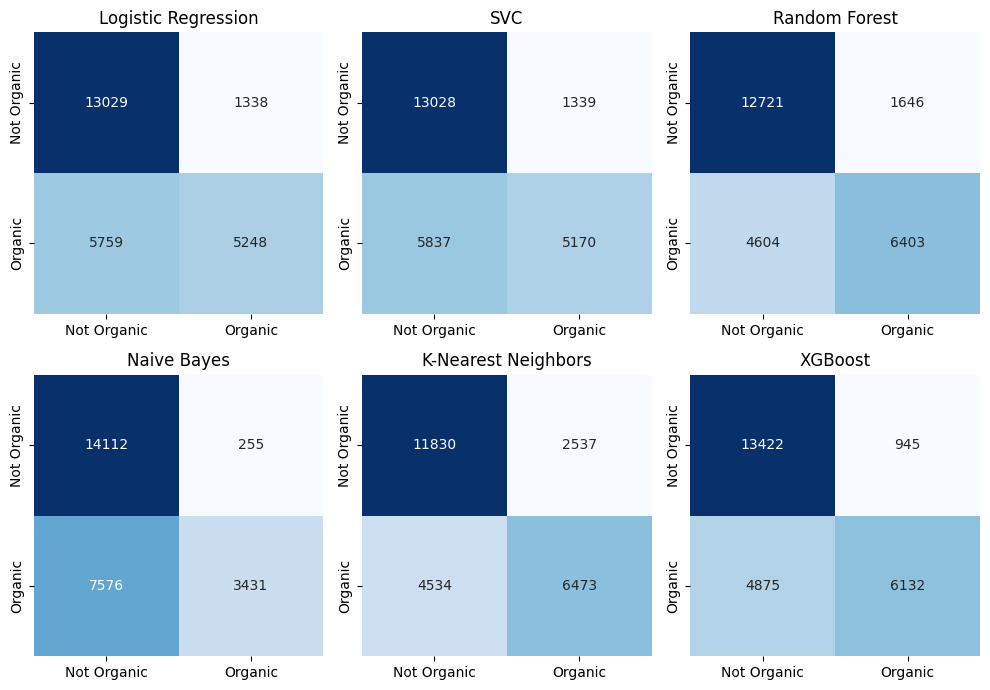

In [23]:
plt.figure(figsize=(10, 7))
tmp = 0
for model_name, _ in models.items():
    cm = results_df.loc[results_df['Model'] == model_name, 'Confusion Matrix'].values[0]
    plt.subplot(2, 3, tmp + 1)
    plot_confusion_matrix(cm, model_name)
    tmp += 1

plt.tight_layout()
plt.show()

Even though the metrics aren't perfect, they're acceptable and not too bad overall. F1 score is the most relevant metric here since it combines both precision and recall. Among the models tested, Random Forest Regressor, XGBoost, and KNN achieved the best F1 scores.

### Grid search & voting classifier

We will perform a grid search for these three models in order to find the best hyperparameters and improve their performance. Once the models are optimized, we will create a voting classifier using soft voting (based on predicted probabilities), with these three models as the estimators.

In [24]:
def grid_search(models, params, X_train, y_train):
    for name, model in models.items():
        print(f"Running GridSearch for {name}...")
        grid = GridSearchCV(model, params[name], cv=3, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        print(f"Best params for {name}: {grid.best_params_}")
        print(f"Best F1 score for {name}: {grid.best_score_:.4f}")
        print("-"*40)

In [25]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'KNN': KNeighborsClassifier()
}

params = {
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'max_depth': [3, 6],
        'learning_rate': [0.1, 0.01]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

In [26]:
grid_search(models, params, X_train, y_train)

Running GridSearch for RandomForest...
Best params for RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 score for RandomForest: 0.6715
----------------------------------------
Running GridSearch for XGBoost...
Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best F1 score for XGBoost: 0.6462
----------------------------------------
Running GridSearch for KNN...
Best params for KNN: {'n_neighbors': 7, 'weights': 'uniform'}
Best F1 score for KNN: 0.6483
----------------------------------------


In [27]:
random_forest_model = RandomForestClassifier(max_depth=None, n_estimators=100, min_samples_split=5)
xgboost_model = XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.1)
knn_model = KNeighborsClassifier(n_neighbors=7, weights='uniform')
voting_model = VotingClassifier(estimators=[
    ('rf', random_forest_model),
    ('knn', knn_model),
    ('xgb', xgboost_model)
], voting='soft')

In [28]:
models = {
    'Random Forest': random_forest_model,
    'XGBoost': xgboost_model,
    'K-Nearest Neighbors': knn_model,
    'Voting Classifier': voting_model
}

In [29]:
results_df, trained_models = train_and_evaluate_models(X_train, y_train, X_test, y_test, models)

In [30]:
results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].head(10)

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.760779,0.811640,0.584083,0.679311
1,XGBoost,0.759991,0.882289,0.515490,0.650763
2,K-Nearest Neighbors,0.729329,0.739664,0.580267,0.650341
3,Voting Classifier,0.766651,0.844021,0.566821,0.678189


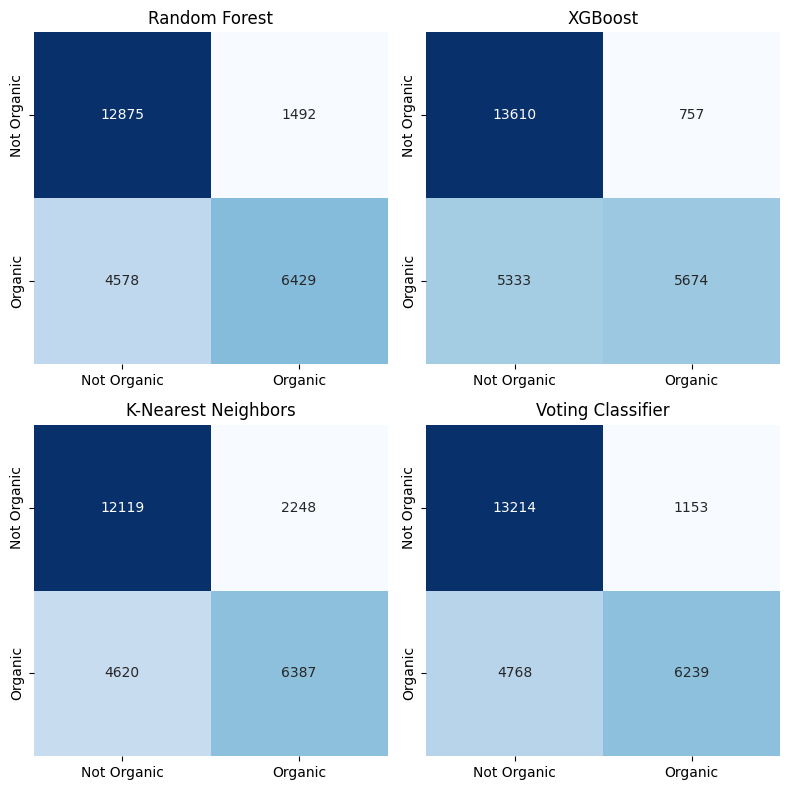

In [32]:
plt.figure(figsize=(8, 8))
tmp = 0
for model_name, _ in models.items():
    cm = results_df.loc[results_df['Model'] == model_name, 'Confusion Matrix'].values[0]
    plt.subplot(2, 2, tmp + 1)
    plot_confusion_matrix(cm, model_name)
    tmp += 1
plt.tight_layout()
plt.show()

The results after hyperparameter optimization are slightly better or similar to those obtained with the default parameters, meaning that no significant improvement was achieved. XGBoost even performed slightly worse after hyperparameter optimization.

### Models by country

Next, we will train separate models for a few selected countries to see whether country-specific modeling leads to improved performance.

In [33]:
data['geo_country'].value_counts()

,count
geo_country,
Brazil,15369
Morocco,8186
Nigeria,6691
Haiti,5717
Italy,4415
...,...
Guernsey,1
St. Lucia,1
Bhutan,1


In [39]:
def analyze_country(data, country_name, target_column):

    data_country = data[data['geo_country'] == country_name].copy()
    data_country.drop(columns=['geo_country'], inplace=True)

    plot_user_distribution(data_country, target_column[0])

    categorical_columns_country = [col for col in data_country.select_dtypes(include=['object']).columns if col not in target_column]
    numerical_columns_country = [col for col in data_country.select_dtypes(include=['number']).columns if col not in target_column]

    data_transformed_country = preprocess_data(data_country, numerical_columns_country, categorical_columns_country, encode=False) # there will be no categorical columns since we dropped 'geo_country'

    y_country = data_transformed_country[target_column]
    X_country = data_transformed_country.drop(columns=target_column)

    X_train_country, X_test_country, y_train_country, y_test_country = train_test_split(
        X_country, y_country, test_size=0.2, random_state=42)

    results_df_country, _ = train_and_evaluate_models(X_train_country, y_train_country, X_test_country, y_test_country, models)

    return results_df_country

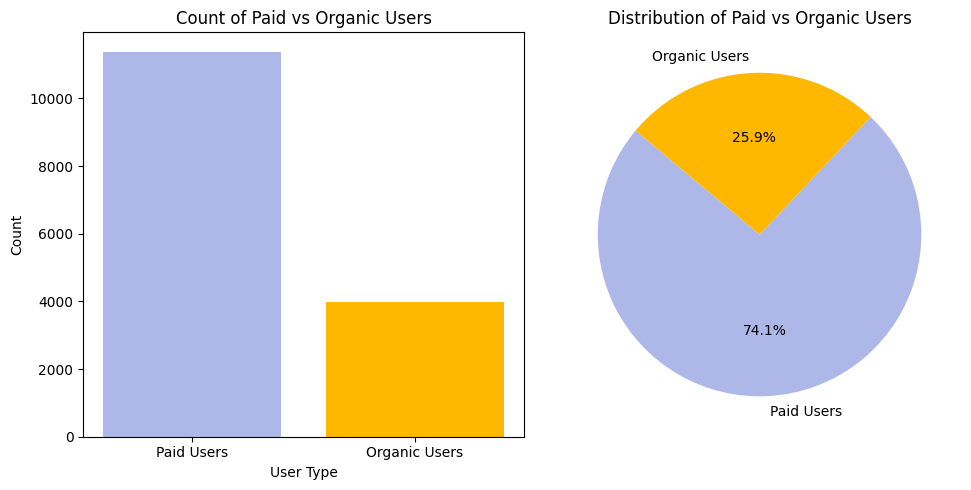

In [40]:
result_df_brazil = analyze_country(data, 'Brazil', target_column)

In [41]:
result_df_brazil[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].head(10)

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.758946,0.697417,0.222877,0.337802
1,XGBoost,0.764151,0.770925,0.206368,0.325581
2,K-Nearest Neighbors,0.745283,0.592593,0.245283,0.346956
3,Voting Classifier,0.761223,0.750000,0.201651,0.317844


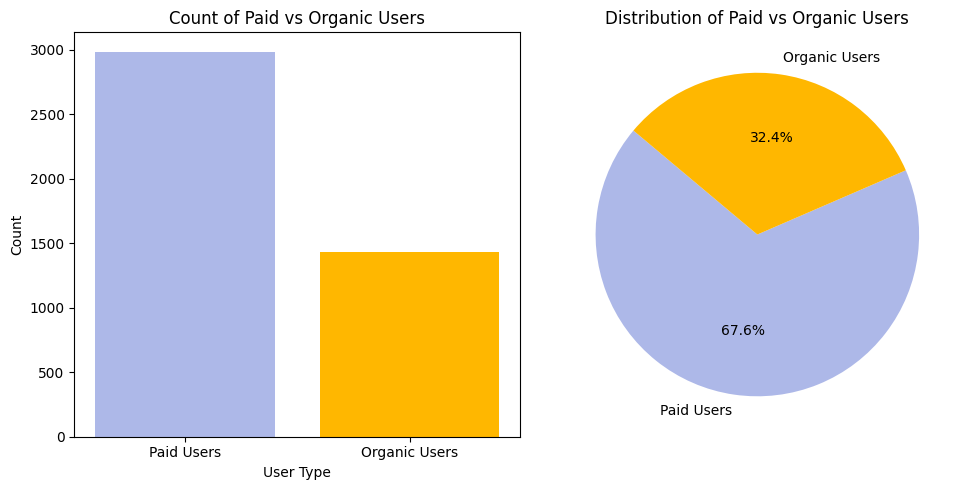

In [42]:
result_df_italy = analyze_country(data, 'Italy', target_column)

In [43]:
result_df_italy[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].head(10)

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.716874,0.551351,0.379182,0.449339
1,XGBoost,0.745187,0.623596,0.412639,0.496644
2,K-Nearest Neighbors,0.729332,0.572816,0.438662,0.496842
3,Voting Classifier,0.747452,0.632184,0.408922,0.496614


We trained separate models for Brazil and Italy, but the performance metrics were worse compared to the model trained on the full dataset. This drop in performance is likely due to increased class imbalance when filtering the data by country, as evident from the bar and pie chart visualizations. Additionally, the smaller dataset size for each individual country may have contributed to the models’ underperformance.

### FCN

Finally, we'll build our own fully connected network (FCN) to try capturing patterns the other models might have missed.

In [44]:
class MyDataset(Dataset):
    def __init__(self, data, target_column):
        self.data = data.drop(columns=target_column).values
        self.targets = data[target_column].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

In [45]:
class MyFCN(nn.Module):
    def __init__(self, input_dim):
        super(MyFCN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [46]:
def eval_fcn(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        eval_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []

        criterion = nn.BCELoss()

        for inputs, target in test_dataloader:
            logits = model(inputs)
            loss = criterion(logits, target)
            eval_loss += loss.item()

            predicted = (logits > 0.5).float()
            correct += (predicted == target).sum().item()
            total += target.size(0)

            all_preds.extend(predicted.squeeze().tolist())
            all_targets.extend(target.squeeze().tolist())

        accuracy = correct / total
        precision = precision_score(all_targets, all_preds)
        recall = recall_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds)

    results = {
        'Loss': eval_loss / len(test_dataloader),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    return pd.DataFrame([results])

In [54]:
def train_fcn(model, train_dataloader, test_dataloader, epochs=30, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    model.train()
    best_epoch = 0
    best_f1 = 0.0
    best_model = None

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0.0
        model.train()
        for inputs, target in train_dataloader:
            logits = model(inputs)
            predicted = (logits > 0.5).float()
            correct += (predicted == target).sum().item()
            loss = criterion(logits, target)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss /= len(train_dataloader)
        accuracy = correct / len(train_dataloader.dataset)
        if (epoch+1) % 5 == 0:
            results = eval_fcn(model, test_dataloader)
            f1_score_value = results['F1 Score'].values[0]
            if f1_score_value > best_f1:
                best_f1 = f1_score_value
                best_model = model.state_dict()
                best_epoch = epoch + 1

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy} Best epoch: {best_epoch}, Best F1: {best_f1:.4f}")

    print("Training complete.")

    model.load_state_dict(best_model)
    results = eval_fcn(model, test_dataloader)
    print("Evaluation results:")
    display(results.head(10))
    return model, results

In [57]:
TEST_PERCENTAGE = 0.2
TRAIN_PERCENTAGE = 1.0 - TEST_PERCENTAGE

test_size = int(TEST_PERCENTAGE * len(data_transformed))
train_size = len(data_transformed) - test_size

dataset = MyDataset(data_transformed, target_column)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

input_dim = data_transformed.drop(columns=target_column).shape[1]
fcn_model = MyFCN(input_dim)
model, results = train_fcn(fcn_model, train_dataloader, test_dataloader, epochs=30, lr=0.01)

Epoch 1/30, Loss: 0.5785, Accuracy: 0.7091313943406636 Best epoch: 0, Best F1: 0.0000
Epoch 2/30, Loss: 0.5636, Accuracy: 0.7275065027193189 Best epoch: 0, Best F1: 0.0000
Epoch 3/30, Loss: 0.5587, Accuracy: 0.7342949475841413 Best epoch: 0, Best F1: 0.0000
Epoch 4/30, Loss: 0.5501, Accuracy: 0.7381177583353039 Best epoch: 0, Best F1: 0.0000
Epoch 5/30, Loss: 0.5495, Accuracy: 0.7396449121147631 Best epoch: 5, Best F1: 0.6225
Epoch 6/30, Loss: 0.5496, Accuracy: 0.7411622132891936 Best epoch: 5, Best F1: 0.6225
Epoch 7/30, Loss: 0.5495, Accuracy: 0.7423149680775597 Best epoch: 5, Best F1: 0.6225
Epoch 8/30, Loss: 0.5523, Accuracy: 0.7418913060613226 Best epoch: 5, Best F1: 0.6225
Epoch 9/30, Loss: 0.5475, Accuracy: 0.7441968156380547 Best epoch: 5, Best F1: 0.6225
Epoch 10/30, Loss: 0.5482, Accuracy: 0.7439012374871916 Best epoch: 10, Best F1: 0.6281
Epoch 11/30, Loss: 0.5470, Accuracy: 0.7438027114369039 Best epoch: 10, Best F1: 0.6281
Epoch 12/30, Loss: 0.5483, Accuracy: 0.74476826672

,Loss,Accuracy,Precision,Recall,F1 Score
0,0.541745,0.753961,0.852592,0.518837,0.645103


## Saving best model

Since the tuned Random Forest, the Voting Classifier (with tuned XGBoost, Random Forest, and KNN), and the FCN all showed the best overall performance with similar metrics, we decided to save these three models.

In [ ]:
joblib.dump(trained_models['Voting Classifier'], '/content/drive/MyDrive/voting_classifier.joblib')
joblib.dump(trained_models['Random Forest'], '/content/drive/MyDrive/random_forest.joblib')
joblib.dump(model, '/content/drive/MyDrive/fcn.joblib')

['/content/drive/MyDrive/fcn.joblib']